## REDUCTION SCRIPT ##

## 1. IMPORT ALL PACKAGES & FUNCTIONS ##

In [1]:
import os
import sys
import numpy as np
import ccdproc as ccdp
import astropy.units as u
from astropy import units as u

import os
from astropy import units as u
import ccdproc as ccdp

import matplotlib.pyplot as plt
from astropy.visualization import (PercentileInterval, ZScaleInterval, ImageNormalize)
from astropy.io import fits
import math

# Import Functions.py file located in hrpo-pipeline
import sys
sys.path.append('/home/idies/workspace/Storage/treed28/persistent/hrpo-pipeline/')
import Functions as f

## 2. GATHER ALL DATA ##

In [2]:
base = "/home/idies/workspace/"
data_dir = "Temporary/treed28/scratch/20240903"

#/home/idies/workspace/Temporary/treed28/scratch/20240903/reduced/

path = os.path.join(base, data_dir)
os.chdir(path)

os.path.exists

# Use ccdp.ImageFileCollection on the current directory to get a 
# list of of all the images in the current directory as strings. 
# images == complete collection of images

images = ccdp.ImageFileCollection(path)
images.summary

file,simple,bitpix,naxis,naxis1,naxis2,bscale,bzero,date-obs,exptime,exposure,set-temp,ccd-temp,xpixsz,ypixsz,xbinning,ybinning,xorgsubf,yorgsubf,readoutm,imagetyp,focuspos,focustem,object,objctra,objctdec,objctalt,objctaz,objctha,sitelat,sitelong,jd,jd-helio,airmass,focallen,aptdia,aptarea,swcreate,sbstdver,telescop,instrume,observer,notes,unit,flipstat,swowner,filter
str19,bool,int64,int64,int64,int64,float64,float64,str19,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str10,str11,int64,float64,str10,str8,str9,str8,str8,str8,str8,str9,float64,float64,float64,float64,float64,float64,str34,str21,str30,str14,str1,str1,str3,str1,str23,object
Bias-001Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:24,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.8628,283.3599,4.4446,30 20 45,-91 04 13,2460557.6502777776,2460557.6487624766,1.8877121610835381,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-002Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:34,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.8165,283.3809,4.4482,30 20 45,-91 04 13,2460557.6503935186,2460557.64887821,1.8895566249126776,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-003Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:45,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.7888,283.3935,4.4504,30 20 45,-91 04 13,2460557.650520833,2460557.6490055164,1.8915903480000875,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-004Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:55,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.7521,283.4101,4.4534,30 20 45,-91 04 13,2460557.6506365743,2460557.64912125,1.8934435927242368,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-005Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:06,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.7055,283.4312,4.4570,30 20 45,-91 04 13,2460557.650763889,2460557.6492485567,1.8954870060905855,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-006Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:16,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.6714,283.4467,4.4598,30 20 45,-91 04 13,2460557.6508796294,2460557.64936429,1.8973490812597464,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-007Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:26,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.6353,283.4631,4.4626,30 20 45,-91 04 13,2460557.6509953705,2460557.6494800234,1.8992153926895932,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-008Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:35,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.6023,283.4781,4.4652,30 20 45,-91 04 13,2460557.651099537,2460557.649

## 3. REDUCTION PREPARATION - MAKE MASTER BIAS ##

In [3]:
# Filter images to get only the bias frames
biases = images.filter(imagetyp="Bias Frame")

# Create a list of CCDData objects from the filtered bias frames
bias_frames = [ccd for ccd in biases.ccds(ccd_kwargs={'unit': u.adu})]

# Combine the bias frames using the median method
mbias = ccdp.combine(bias_frames, method='median')

# Save the master bias frame, overwriting if necessary
mbias.write("reduced/mbias.fit", overwrite=True)

## 4. REDUCTION PREPARATION - MAKE MASTER DARK ##

In [4]:
# Filter images to get only the dark frames
darks = images.filter(imagetyp="Dark Frame")

# Initialize the lists for reduced darks and exposure times
exptimes = []
red_darks = []

# Iterate over each dark frame, subtracting the master bias and storing results
#for ccd in darks.ccds(ccd_kwargs={'unit': u.adu}):

for ccd in darks.ccds(ccd_kwargs={'unit':u.adu}):    
    # Subtract the master bias from each dark frame
    #cleaned_dark = ccdp.subtract_bias(ccd, mbias)
    cleaned_dark = ccdp.subtract_bias(ccd, mbias)
    
    # Append the cleaned dark frame to the list
    red_darks.append(cleaned_dark)
    
    # Append the exposure time to the exptimes list
    exptimes.append(cleaned_dark.header["exptime"])
    
# Convert the exposure times list to a numpy array
exptimes = np.array(exptimes)

# Create master dark frame with `ccdp.combine`. Use the median method, set `scale=1/exptimes`, and set `unit="adu"`. I will refer to this as `mdark` 
mdark = ccdp.combine(red_darks, method='median', scale=1/exptimes, unit=u.adu) #unit=u.adu

# Set the `"exposure"` and `"exptime"` header keywords in `mdark.header` to 1
mdark.header["exptime"] = 1
mdark.header["exposure"] = 1

# Ensure the 'reduced' directory exists
output_directory = "reduced"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
# Save `mdark` in the reduced data directory
mdark.write(os.path.join(output_directory, "mdark.fit"), overwrite=True)
#mdark.write("reduced/mdark.fit", overwrite=True)

## 5. Reduction Preparation: Make the master flat frames

In [5]:
#import numpy as np
#import os
#from astropy import units as u
#import ccdproc as ccdp

# Define a list of filter names
filters = ["Bessel B", "Bessel V", "Bessel R"]

# Create an empty dictionary to store the master flats for each filter
mflats = {}

# Ensure the 'reduced' directory exists
output_directory = "reduced"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over the filters
for filt in filters:
    # Filter the images to get only the flat frames for the current filter
    flats = images.filter(imagetyp="Flat Field", filter=filt)
    
    # Create an empty list to store the reduced flats for the current filter
    red_flats = []
    
    # Iterate over the flat frames
    for flat in flats.ccds(ccd_kwargs={'unit': u.adu}):
        # Subtract the master bias from each flat
        flat_bias_subtracted = ccdp.subtract_bias(flat, mbias)
        
        # Subtract the master dark from each flat, with scaling
        flat_reduced = ccdp.subtract_dark(flat_bias_subtracted, mdark, 
                                          scale=True, 
                                          exposure_time='exptime', 
                                          exposure_unit=u.s)
        
        # Append the reduced flat to the red_flats list
        red_flats.append(flat_reduced)
    
    # Prepare a unique filename for the current filter
    filt_string = filt.replace(" ", "_")
    fname = os.path.join(output_directory, f"{filt_string}_flat.fit")
    
    # Combine the reduced flats into a master flat for the current filter
    mflat = ccdp.combine(red_flats, method='median', unit=u.adu)
    
    # Save the master flat to the reduced directory
    mflat.write(fname, overwrite=True)
    
    # Add the master flat to the dictionary with the filter name as the key
    mflats[filt] = mflat.copy()



## 6. REDUCE THE DATA

In [6]:
#import os
#from astropy import units as u
#import ccdproc as ccdp

# Filter images to get only the light frames
lights = images.filter(imagetyp="Light Frame")

# Ensure the 'reduced' directory exists
output_directory = "reduced"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over the light frames and reduce them
for light, filename in zip(lights.ccds(ccd_kwargs={'unit': u.adu}), lights.files):
    # Reduce the light frame using ccd_process
    reduced_light = ccdp.ccd_process(
        light,
        master_bias=mbias,
        dark_frame=mdark,
        master_flat=mflats[light.header["Filter"]],
        dark_scale=True,
        exposure_key='exptime',
        exposure_unit=u.s
    )

    # Prepare the output filename by inserting '_reduced' before the '.fit' extension
    original_filename = os.path.basename(filename)
    reduced_filename = f"{os.path.splitext(original_filename)[0]}_reduced.fit"
    output_path = os.path.join(output_directory, reduced_filename)

    # Write out the reduced light frame to the reduced data directory
    reduced_light.write(output_path, overwrite=True)

    print(f"Reduced file saved as: {reduced_filename}")


Reduced file saved as: ET_NCG7009-001B_reduced.fit
Reduced file saved as: ET_NCG7009-001R_reduced.fit
Reduced file saved as: ET_NCG7009-001V_reduced.fit
Reduced file saved as: JS_M57-001B_reduced.fit
Reduced file saved as: JS_M57-001R_reduced.fit
Reduced file saved as: JS_M57-001V_reduced.fit
Reduced file saved as: KG_M11-001B_reduced.fit
Reduced file saved as: KG_M11-001R_reduced.fit
Reduced file saved as: KG_M11-001V_reduced.fit
Reduced file saved as: LBM8-001B_reduced.fit
Reduced file saved as: LBM8-001R_reduced.fit
Reduced file saved as: LBM8-001V_reduced.fit
Reduced file saved as: MB_M15-001B_reduced.fit
Reduced file saved as: MB_M15-001R_reduced.fit
Reduced file saved as: MB_M15-001V_reduced.fit
Reduced file saved as: MN_M27-001B_reduced.fit
Reduced file saved as: MN_M27-001R_reduced.fit
Reduced file saved as: MN_M27-001V_reduced.fit
Reduced file saved as: TB_M31-001B_reduced.fit
Reduced file saved as: TB_M31-001R_reduced.fit
Reduced file saved as: TB_M31-001V_reduced.fit
Reduced

## 7. SHOW REDUCED IMAGES ##

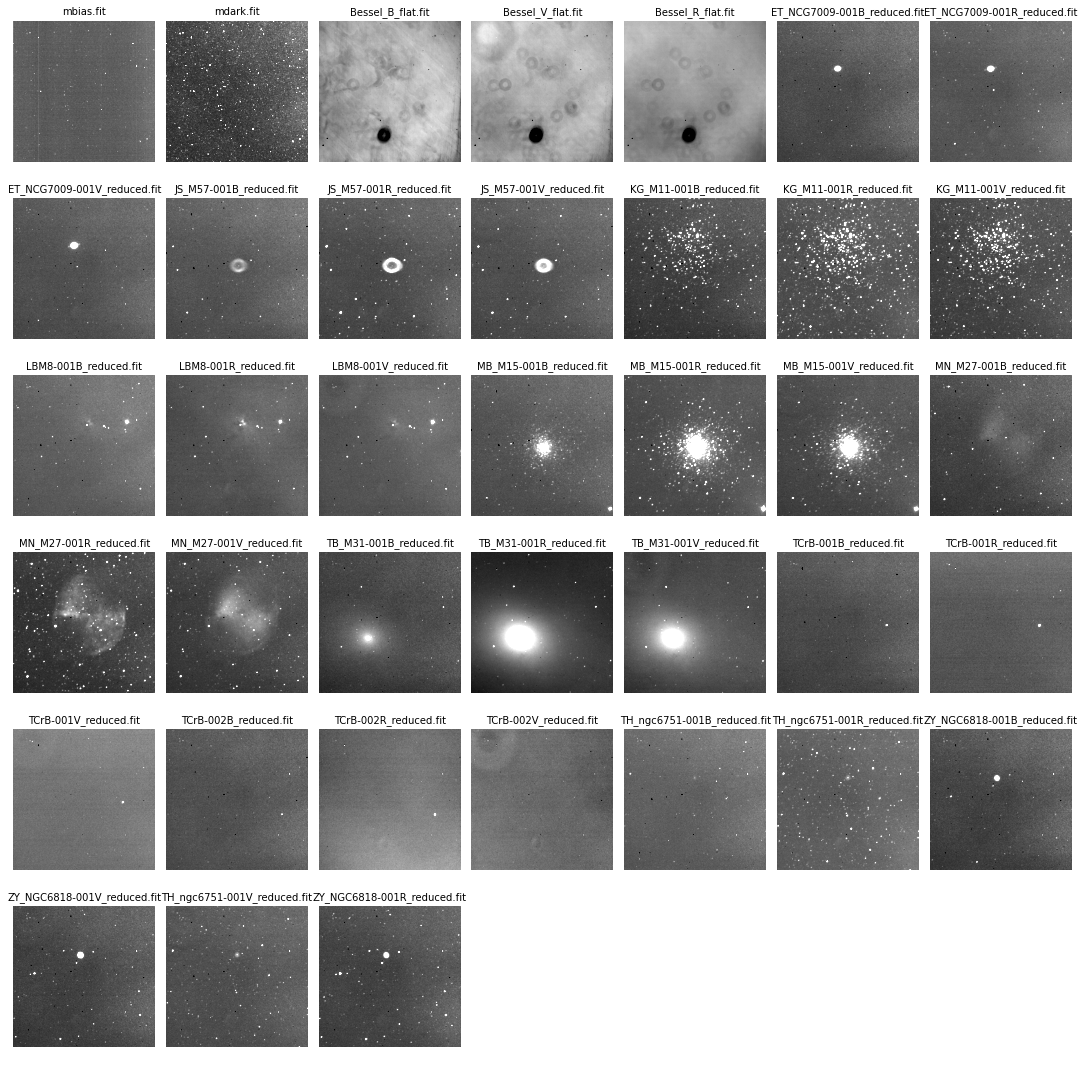

In [7]:
#Corrected Cell for above Cell
import os
import math
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.io import fits

# Define the directory containing the reduced FITS files
fits_directory = '/home/idies/workspace/Temporary/treed28/scratch/20240903/reduced/'

# Get the list of all FITS files in the directory
fits_files = [f for f in os.listdir(fits_directory) if f.endswith(('.fit', '.fits'))]

# Calculate the grid size (rows and columns) for displaying the images
num_images = len(fits_files)
cols = math.ceil(math.sqrt(num_images))  # Number of columns
rows = math.ceil(num_images / cols)  # Number of rows

# Create a figure to display all the images in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten axes to iterate easily

# Loop over the FITS files and display each image in the grid
for i, filename in enumerate(fits_files):
    file_path = os.path.join(fits_directory, filename)

    # Open the FITS file and extract the data
    with fits.open(file_path) as fits_image:
        image_data = fits_image[0].data

    # Normalize the image data for better visualization
    norm = ImageNormalize(image_data, interval=ZScaleInterval())

    # Display the image in the corresponding subplot
    axes[i].imshow(image_data, cmap='gray', norm=norm)
    axes[i].set_title(filename, fontsize=10)
    axes[i].axis('off')  # Hide axis for better presentation

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

## GAIN ASSIGNMENT - Camera Characteriazation w/ Calibration Images ##

## --> Estimate the Readout Noise in units of ADU ##


In [8]:
##Gain

# Main process
directory = '/home/idies/workspace/Temporary/treed28/scratch/20240903/'  # Directory containing bias FITS files

# Load the bias images (only those starting with "Bias" and ending with ".fit")
bias_images = f.load_fits_images(directory)

# Estimate the average readout noise
average_noise = f.readout_noise_from_bias_images(bias_images)

if average_noise is not None:
    print("Average Readout Noise (ADU):", average_noise)
else:
    print("Failed to calculate average readout noise.")


Average Readout Noise (ADU): 11.220110190069471


## --> Calculate Gain, g, & Readout Noise in units of Electrons ##

In [9]:
import importlib
import Functions as f
importlib.reload(f)


# Main process
directory = '/home/idies/workspace/Temporary/treed28/scratch/20240903/'  # Directory containing flat and bias FITS files

# Estimate the average readout noise
#average_noise = f.readout_noise_from_bias_images(bias_images)

# Specify the filter type you want to load (e.g., "B.fit", "V.fit", "R.fit")
filter_type = "B.fit"  # Change this to "V.fit" or "R.fit" depending on the filter

# Load the flat field images with the specified filter type (those starting with "DomeFlat" and ending with the filter)
flat_images = f.load_fits_images_by_filter(directory, "DomeFlat", filter_type)

# Load the bias images (those starting with "Bias")
bias_images = f.load_fits_images(directory) #, "Bias", ".fit")

# Ensure that we have at least two flat field images and two bias images
if len(flat_images) >= 2 and len(bias_images) >= 2:
    # Use the first two flat images and the first two bias images to calculate gain and readout noise
    gain, readout_noise = f.calculate_gain_and_readout_noise(flat_images[0], flat_images[1], bias_images[0], bias_images[1])
    
    # Print the results
    print("Average Readout Noise (ADU):", average_noise)
    print(f"Gain (e-/ADU): {gain}")
    print(f"Readout Noise (e-): {readout_noise}")
else:
    print("Not enough flat field or bias images to perform calculations.")


Average Readout Noise (ADU): 11.220110190069471
Gain (e-/ADU): 1.5545024295168712
Readout Noise (e-): 17.441688549909998


## PLATE SOLVE SCRIPT ##